**Pavlos Spanoudakis (sdi1800184)**\
**Theodora Troizi (sdi1800197)**
### Homework 2 on Data Mining Techniques class
## Goodreads Books Recommendation & Classification

In [1]:
### Standard Modules ###

# Type Hints
from typing import Iterable, List, Callable

# from typing_extensions import NotRequired #, ParamSpec

from collections import defaultdict
import ast
import string
import re
import io
import requests
import gc
# import warnings

### Non-standard Modules ###

from PIL import Image
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
# nltk
import nltk
nltk.download('stopwords')
# ipynb-specific
from IPython.display import display

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Importing custom modules and reading the dataset

In [2]:
CSV_PATH = './books_1.Best_Books_Ever.csv'
"""
     The path to read the dataset from.
     It should be set to a relative path under `/content/gdrive/My Drive/`,
     if expected to be found from Google Drive.
"""

USE_GDRIVE = True
"""

"""

def mountDrive() -> str:
    """
        Attempts to mount Google Drive, if `USE_GDRIVE` is `True`.
        If this is the case and this notebook is running on Google Colab
        (`google.colab` module is available), it returns the absolute mount path.
        Otherwise, it returns `.`
    """
    try:
        from google.colab import drive # type: ignore
        drive.mount('/content/gdrive')
        return '/content/gdrive/MyDrive/goodreads/'
    except ImportError:
        return '.'

if USE_GDRIVE:
    importsPath = mountDrive()
    %cd {importsPath}

### Custom Modules ###

from modules.utils import printMd, printDatasetShape, getStopWordsSet, DataColumn, runWithNoWarnings
from modules.year_extractor import YearExtractor
from modules.generators import AnswerGenerator, TopColumnValuesAnswerGenerator
from modules.questions import AnswerGeneratorQuestion, TopColumnValuesQuestion
from modules.recommender import BookRecommender

def readDataset() -> pd.DataFrame:
    """
        Reads the dataset using `CSV_PATH`.
    """
    return pd.read_csv(CSV_PATH)

Mounted at /content/gdrive
/content/gdrive/MyDrive/goodreads


### Dataset Preprocessing

In [3]:
def getFilteredColumns(df: pd.DataFrame, colsToIgnore: Iterable[str]) -> List[str]:
    return [ c for c in df.columns if c not in colsToIgnore ]

def extraDatasetNans(df: pd.DataFrame):
    """
        Returns a single column, boolean `DataFrame`, indicating `df`
        rows that should be considered NaN as well.
    """ 

    return (
        (df[DataColumn.RATINGSBYSTARS] == '[]')
        |
        (df[DataColumn.GENRES] == '[]')
    )

def dropNaNRows(df: pd.DataFrame, colsToIgnore: Iterable[str]):
    """
        Drops rows in `df` with NaN values in columns *not* in `colsToIgnore`.
    """

    cols = getFilteredColumns(df, colsToIgnore)

    df.dropna(subset=cols, inplace=True)
    df.drop(df[extraDatasetNans(df)].index, inplace=True)
    df.reset_index(inplace=True, drop=True)

def countMissingByColumn(df: pd.DataFrame, colsToIgnore: Iterable[str]):
    """
        Returns a `DataFrame` which includes one row for each column
        of `df` with at least one missing value.
        
        Each row contains the name of the respective column,
        as well as the amount of missing values for that column.
    """

    cols = getFilteredColumns(df, colsToIgnore)
    nans = df[cols].isna().sum()
    extras = df[[DataColumn.RATINGSBYSTARS, DataColumn.GENRES]] 
    extras = (extras[extraDatasetNans(extras)] == '[]').sum()

    total = pd.concat([nans.loc[nans > 0], extras.loc[extras > 0]])
    ret = pd.DataFrame(total.sort_values(ascending=False))
    ret.columns = ['Missing']
    return ret

In [4]:
dataDf = readDataset()
printDatasetShape(dataDf)

Dataset Shape:
Rows: 52478, Columns: 25


In [5]:
colsToIgnore = [
    DataColumn.EDITION,
    DataColumn.SERIES,
    DataColumn.FIRSTPUBLISHDATE,
    DataColumn.PRICE,
    DataColumn.BOOKFORMAT,
    DataColumn.LIKEDPERCENT,
    DataColumn.COVERIMG,
    DataColumn.CHARACTERS,
    DataColumn.SETTING
]
countMissingByColumn(dataDf, colsToIgnore)

,Missing
genres,4623
language,3806
publisher,3696
pages,2347
ratingsByStars,1423
description,1338
publishDate,880


In [6]:
dropNaNRows(dataDf, colsToIgnore)
dataDf.drop(labels=colsToIgnore, axis=1, inplace=True)
printDatasetShape(dataDf)
countMissingByColumn(dataDf, colsToIgnore)

Dataset Shape:
Rows: 41572, Columns: 16


,Missing


In [7]:
class RatingStarColumns:
    
    starLabels = [
        DataColumn.RATINGSTAR5,
        DataColumn.RATINGSTAR4,
        DataColumn.RATINGSTAR3,
        DataColumn.RATINGSTAR2,
        DataColumn.RATINGSTAR1
    ]
    allLabels = starLabels + [DataColumn.RATINGSBYSTARS]

    @staticmethod
    def extractColumns(df: pd.DataFrame) -> pd.DataFrame:        
        for col in RatingStarColumns.starLabels:
            if col in df.columns:
                return df

        ratingStarArray = np.zeros(shape=(df.shape[0], len(RatingStarColumns.starLabels)), dtype=int)
        idxIter = iter(range(df.shape[0]))

        def addRatingStarRow(ratingsByStarsStr: str):
            idx = next(idxIter)
            ratingsList: Iterable[str] = ast.literal_eval(ratingsByStarsStr)
            for j, r in enumerate(ratingsList):
                ratingStarArray[idx][j] = int(r)

        df[DataColumn.RATINGSBYSTARS].apply(addRatingStarRow)

        temp = pd.DataFrame(columns=RatingStarColumns.starLabels, data=ratingStarArray)
        return pd.concat((df, temp), axis=1)
    
    @staticmethod
    def testRatings(df: pd.DataFrame):
        for _, row in df.iterrows():
            a: List[str] = ast.literal_eval(row[DataColumn.RATINGSBYSTARS])
            b = [str(row[col]) for col in (RatingStarColumns.starLabels)]
            if a != b:
                raise AssertionError(f'{a} != {b}')

dataDf = RatingStarColumns.extractColumns(dataDf)
RatingStarColumns.testRatings(dataDf)
dataDf[RatingStarColumns.allLabels].head()

,ratingStar5,ratingStar4,ratingStar3,ratingStar2,ratingStar1,ratingsByStars
0,3444695,1921313,745221,171994,93557,"['3444695', '1921313', '745221', '171994', '93..."
1,1593642,637516,222366,39573,14526,"['1593642', '637516', '222366', '39573', '14526']"
2,2363896,1333153,573280,149952,80794,"['2363896', '1333153', '573280', '149952', '80..."
3,1617567,816659,373311,113934,76770,"['1617567', '816659', '373311', '113934', '767..."
4,1751460,1113682,1008686,542017,548674,"['1751460', '1113682', '1008686', '542017', '5..."


In [8]:
dataDf[DataColumn.PUBLISHYEAR] = dataDf[DataColumn.PUBLISHDATE].apply(YearExtractor.extractYear)

In [9]:
def extractSingleGenres(df: pd.DataFrame):

    def singleGenreExtractor(s: str):
        genres: List[str] = ast.literal_eval(s)
        return genres[0] if len(genres) else 'NO_GENRE'

    return df[DataColumn.GENRES].apply(singleGenreExtractor)

dataDf[DataColumn.GENRESINGLE] = extractSingleGenres(dataDf)

### Data Observation

**1.** Book Ratings histogram

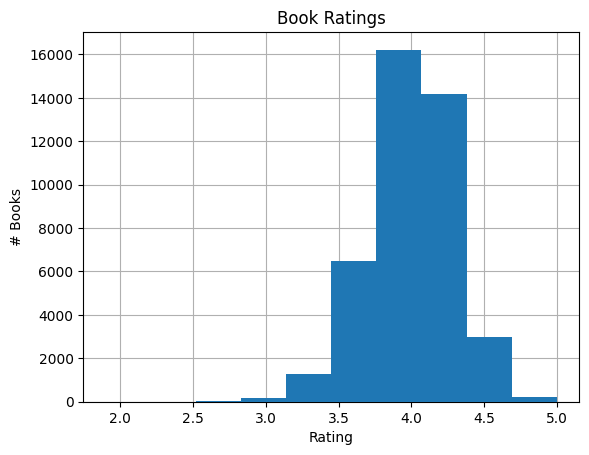

In [10]:
def displayColumnHistogram(
    df: pd.DataFrame,
    col: str,
    xlabel: str,
    ylabel: str = '# Books',
    title: str = ''
):
    """
        Displays the Histogram for column `col` of `df`.
        - `xlabel`: the label for x-axis.
        - `ylabel`: the label for y-axis.
    """

    ax = plt.subplot()
    ax.set_title(title if title else col)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    df[col].hist(ax=ax, grid=True, zorder=3)

printMd('**1.** Book Ratings histogram')
displayColumnHistogram(dataDf, col=DataColumn.RATING, xlabel='Rating', title='Book Ratings')

In [11]:
class TopBooksAnswerGenerator(AnswerGenerator[AnswerGeneratorQuestion]):
    """
        Used to generate `DataFrame` answers on questions regarding
        the top books based on a specific column value.
    """ 
    
    def createDataFrameAnswer(self, q: AnswerGeneratorQuestion, df: pd.DataFrame):
        results = df.sort_values(by=q['col'], ascending=False)
        return results[[DataColumn.TITLE, q['col']]]

In [12]:
questions: List[AnswerGeneratorQuestion] = [
    {
        'qnum': '2',
        'qtitle': 'Top 10 books with the most pages',
        'col': DataColumn.PAGES,
        'limit': 10,
        'dataFilter': None
    },
    {
        'qnum': '3',
        'qtitle': 'Top 10 books with the most 5-star ratings (min 10000)',
        'col': DataColumn.RATINGSTAR5,
        'limit': 10,
        'dataFilter': lambda df: df[df[DataColumn.RATINGSTAR5] > 10000]
    },
]

TopBooksAnswerGenerator().registerQuestions(questions).generateAnswers(dataDf)

**2**. Top 10 books with the most pages:

,title,pages
30698,The Marx Sisters: A Kathy Kolla and David Broc...,999
304,The Wise Man's Fear,994
656,A Breath of Snow and Ashes,993
35898,Hamzanama: The Adventures of Amir Hamza,992
27195,The Ball is Round: A Global History of Soccer,992
14843,The Endymion Omnibus,992
11779,The Braided Path,992
17695,Three Novels of Old New York: The House of Mir...,992
12217,The Last Lion: Winston Spencer Churchill: Visi...,992
36110,"1,000 Places to See Before You Die",992


**3**. Top 10 books with the most 5-star ratings (min 10000):

,title,ratingStar5
32,Harry Potter and the Sorcerer's Stone,4578137
0,The Hunger Games,3444695
2,To Kill a Mockingbird,2363896
71,Harry Potter and the Deathly Hallows,2038930
93,Harry Potter and the Prisoner of Azkaban,1892635
10,The Fault in Our Stars,1784471
4,Twilight,1751460
103,Harry Potter and the Goblet of Fire,1729403
105,Harry Potter and the Half-Blood Prince,1646703
3,Pride and Prejudice,1617567


In [13]:
def displayMostCommonColumnWords(df: pd.DataFrame, col: str, n: int):
    text = ' '.join(df[col]).lower()
    
    results = WordCloud(stopwords=getStopWordsSet()).process_text(text)

    resultsDf = pd.DataFrame(results.items())
    resultsDf.columns = ['Word', 'Frequency']
    resultsDf.sort_values(by='Frequency', inplace=True, ascending=False)
    resultsDf.reset_index(drop=True, inplace=True)
    resultsDf.index += 1

    printMd(f'Most common words in column `{col}`:')
    display(resultsDf.head(n))

displayMostCommonColumnWords(dataDf, DataColumn.TITLE, 10)

Most common words in column `title`:

,Word,Frequency
1,life,721
2,love,603
3,world,456
4,girl,449
5,book,440
6,de,373
7,secret,368
8,story,364
9,one,347
10,god,344


In [14]:
questions: List[TopColumnValuesQuestion] = [
    {
        'qnum': '5',
        'qtitle': 'Top 10 Authors with the most books',
        'col': DataColumn.AUTHOR,
        'countCol': TopColumnValuesAnswerGenerator.COUNT_ROWS,
        'limit': 10,
        'extractor': lambda s: re.split(r'[,(]', s, maxsplit=1)[0].strip(),
    },    
    {
        'qnum': '6',
        'qtitle': 'Top 10 Authors with the most ratings',
        'col': DataColumn.AUTHOR,
        'countCol': DataColumn.NUMRATINGS,
        'limit': 10,
        'useExtracted': True
    },
    {
        'qnum': '8',
        'qtitle': 'Top 10 Languages used in the most books',
        'col': DataColumn.LANGUAGE,
        'countCol': TopColumnValuesAnswerGenerator.COUNT_ROWS,
        'limit': 10,
    },
    {
        'qnum': '9',
        'qtitle': 'Top 10 Publishers with the most books',
        'col': DataColumn.PUBLISHER,
        'countCol': TopColumnValuesAnswerGenerator.COUNT_ROWS,
        'limit': 10,
    }
]

def buildYearFilter(y: int) -> Callable[[pd.DataFrame], pd.DataFrame]:
    return lambda df: df[df[DataColumn.PUBLISHYEAR] == y]

for i, y in enumerate(range(2000, 2016, 5)):
    questions.append({
        'qnum': f'7({i + 1})',
        'qtitle': f'Top 10 Authors with the most books in {y}',
        'col': DataColumn.AUTHOR,
        'countCol': TopColumnValuesAnswerGenerator.COUNT_ROWS,
        'limit': 10,
        'dataFilter': buildYearFilter(y),
    })
questions = sorted(questions, key=lambda q: q['qnum'])
TopColumnValuesAnswerGenerator().registerQuestions(questions).generateAnswers(dataDf)

**5**. Top 10 Authors with the most books:

,Author,Books
1,Stephen King,90
2,Nora Roberts,89
3,James Patterson,82
4,Agatha Christie,81
5,Erin Hunter,67
6,J.D. Robb,63
7,Terry Pratchett,62
8,Francine Pascal,60
9,Carolyn Keene,57
10,Karen Kingsbury,57


**6**. Top 10 Authors with the most ratings:

,Author,Total numRatings
1,J.K. Rowling,24342485
2,Stephen King,12994174
3,Suzanne Collins,11836703
4,Stephenie Meyer,10562763
5,Rick Riordan,8432058
6,J.R.R. Tolkien,8086696
7,Dan Brown,7014203
8,John Green,6793133
9,Cassandra Clare,6650456
10,George Orwell,6230842


**7(1)**. Top 10 Authors with the most books in 2000:

,Author,Books
1,Agatha Christie,7
2,Larry McMurtry,5
3,Lawrence Block (Goodreads Author),5
4,Katherine Applegate,5
5,Linda Howard,4
6,P.G. Wodehouse,4
7,Jude Watson (Goodreads Author),3
8,Elizabeth Peters,3
9,Francine Rivers (Goodreads Author),3
10,"Jude Watson (Goodreads Author), Cliff Nielsen ...",3


**7(2)**. Top 10 Authors with the most books in 2005:

,Author,Books
1,Terry Pratchett,9
2,"Bodie Thoene (Goodreads Author), Brock Thoene",9
3,Georgette Heyer,9
4,R.L. Stine (Goodreads Author),8
5,Ted Dekker (Goodreads Author),8
6,Tamora Pierce (Goodreads Author),8
7,Laurell K. Hamilton (Goodreads Author),7
8,Nora Roberts (Goodreads Author),7
9,C.S. Lewis,7
10,"CLAMP, William Flanagan (Translator)",7


**7(3)**. Top 10 Authors with the most books in 2010:

,Author,Books
1,"Mary Pope Osborne, Salvatore Murdocca (Illustr...",8
2,Laurann Dohner,7
3,Joey W. Hill (Goodreads Author),5
4,Rachel Caine (Goodreads Author),5
5,Jim Butcher (Goodreads Author),5
6,Meg Cabot (Goodreads Author),5
7,Gena Showalter (Goodreads Author),5
8,Christopher Pike,5
9,"Will Durant, Ariel Durant, عبد الرحمن عبد الله...",5
10,T.M. Nielsen,4


**7(4)**. Top 10 Authors with the most books in 2015:

,Author,Books
1,Jennifer L. Armentrout (Goodreads Author),5
2,Anna Gallegos (Goodreads Author),4
3,Penny Reid (Goodreads Author),4
4,Anne Jolin (Goodreads Author),4
5,Meredith Wild (Goodreads Author),4
6,Suzanne Wright (Goodreads Author),3
7,Sherrilyn Kenyon (Goodreads Author),3
8,Marissa Meyer (Goodreads Author),3
9,Jennifer Donnelly (Goodreads Author),3
10,C.S. Lewis,3


**8**. Top 10 Languages used in the most books:

,Language,Books
1,English,37005
2,Arabic,744
3,Spanish,519
4,French,494
5,German,404
6,Indonesian,300
7,Portuguese,298
8,Italian,214
9,Dutch,192
10,Turkish,173


**9**. Top 10 Publishers with the most books:

,Publisher,Books
1,Vintage,559
2,HarperCollins,494
3,Penguin Books,410
4,Ballantine Books,383
5,Bantam,346
6,Avon,305
7,Pocket Books,304
8,Del Rey,282
9,Berkley,276
10,Tor Books,275


**10.** Relationship between number of pages and ratings

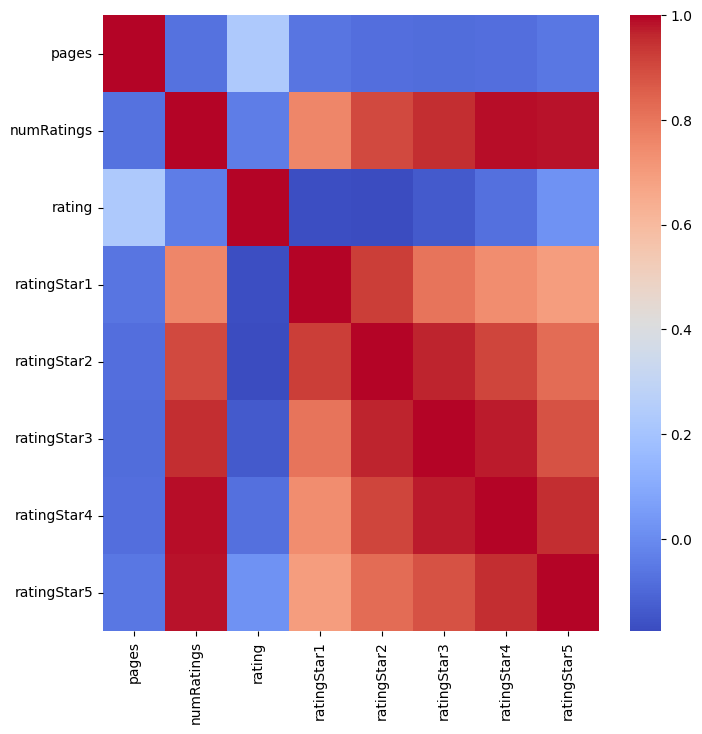

In [15]:
def drawHeatmap(df: pd.DataFrame, ax: plt.Axes, cmap: str = "coolwarm", **kwargs):
    _ = sns.heatmap(df.corr(), ax=ax, cmap=cmap, **kwargs)

_, axes = plt.subplots(1, 1, figsize=(8,8))
cols = [
    DataColumn.PAGES,
    DataColumn.NUMRATINGS,
    DataColumn.RATING,
    DataColumn.RATINGSTAR1,
    DataColumn.RATINGSTAR2,
    DataColumn.RATINGSTAR3,
    DataColumn.RATINGSTAR4,
    DataColumn.RATINGSTAR5
]

def pageStrToInt(s: str):
    try:
        return int(s)
    except ValueError:
        return int(s.split(maxsplit=1)[0])

dataDf[DataColumn.PAGES] = dataDf[DataColumn.PAGES].apply(pageStrToInt)
drawHeatmap(dataDf[dataDf[DataColumn.PAGES] > 1000][cols], axes)

In [16]:
def countListRowStrings(d: "defaultdict[str, int]", s: str, listExtractor: Callable[[str], List[str]]):
    items: List[str] = listExtractor(s)
    for i in items:
        d[i] += 1

def awardTitlesExtractor(awardListStr: str) -> List[str]:    
    awardList: List[str] = ast.literal_eval(awardListStr)
    awards = []
    for s in awardList:
        awards.append(re.sub(fr'[(]{YearExtractor.YEAR_RE_NO_GROUP}[)]', repl='', string=s).strip())
    return awards

TopColumnValuesAnswerGenerator().registerQuestions([
    {
        'qnum': '11',
        'qtitle': 'Top Genres of the most books',
        'col': DataColumn.GENRES,
        'countCol': TopColumnValuesAnswerGenerator.COUNT_ROWS,
        'limit': 10,
        'counter': lambda d, s, _: countListRowStrings(d, s, ast.literal_eval)
    },
    {
        'qnum': '12',
        'qtitle': 'Top Awards of the most books',
        'col': DataColumn.AWARDS,
        'countCol': TopColumnValuesAnswerGenerator.COUNT_ROWS,
        'limit': 10,
        'counter': lambda d, s, _: countListRowStrings(d, s, awardTitlesExtractor)
    }
]).generateAnswers(dataDf)

**11**. Top Genres of the most books:

,Genres,Books
1,Fiction,28657
2,Fantasy,13481
3,Romance,13159
4,Young Adult,10453
5,Contemporary,8919
6,Nonfiction,7310
7,Adult,7228
8,Novels,7224
9,Historical Fiction,7098
10,Mystery,7075


**12**. Top Awards of the most books:

,Awards,Books
1,Dorothy Canfield Fisher Children's Book Award ...,317
2,Lincoln Award Nominee,246
3,Rhode Island Teen Book Award Nominee,214
4,Carnegie Medal Nominee,160
5,Goodreads Choice Award Nominee for Young Adult...,155
6,Rebecca Caudill Young Readers' Book Award Nominee,138
7,Goodreads Choice Award Nominee for Fiction,137
8,Goodreads Choice Award Nominee for Romance,136
9,Missouri Gateway Readers Award Nominee,136
10,Goodreads Choice Award Nominee for Young Adult...,134


In [17]:
TopColumnValuesAnswerGenerator().registerQuestion({
    'qnum': '13',
    'qtitle': 'Books published by year',
    'col': DataColumn.PUBLISHYEAR,
    'countCol': TopColumnValuesAnswerGenerator.COUNT_ROWS,
    'limit': 15
}).generateAnswers(dataDf)

**13**. Books published by year:

,Publishyear,Books
1,2012,2642
2,2006,2432
3,2013,2418
4,2011,2399
5,2010,2235
6,2007,2217
7,2009,2014
8,2014,1995
9,2005,1902
10,2008,1866


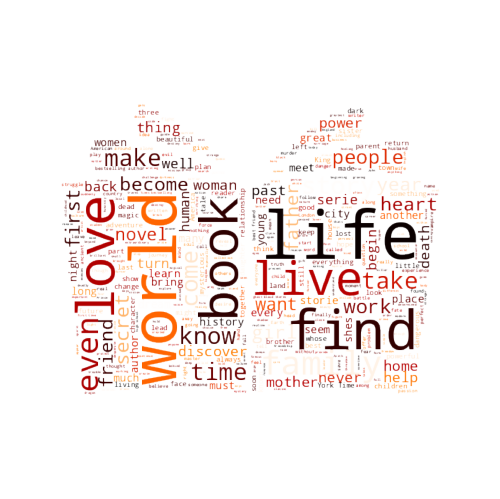

<Figure size 4000x2000 with 0 Axes>

Top 10 most popular words used in book descriptions:

,Word
1,life
2,world
3,find
4,book
5,love
6,live
7,family
8,even
9,story
10,time


In [18]:
def displayWordcloud(text: str) -> WordCloud:

    def downloadImageMask() -> "np.ndarray | None":
        IMG_PATH = 'https://img.freepik.com/premium-vector/book-logo_535345-3487.jpg'

        res = requests.get(IMG_PATH)

        if res.ok:
            return np.array( Image.open(io.BytesIO(res.content)) )
        else:
            return None

    cloud = WordCloud(
        background_color="rgba(255, 255, 255, 0)", mode="RGBA",
        colormap='gist_heat',
        width=2000, height=1000,
        max_words=500,
        min_word_length=4,
        stopwords=getStopWordsSet(),
        mask=downloadImageMask()
    ).generate(text)

    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.imshow(cloud, interpolation='bilinear')
    plt.figure(figsize=(40, 20))
    plt.show()

    return cloud

def displayTopWordcloudWords(wcloud: WordCloud, n: int):
    printMd(f'Top {n} most popular words used in book descriptions:')
    topWords = pd.DataFrame(wcloud.words_.keys())
    topWords.columns=['Word']
    topWords.index += 1
    display(topWords.head(n))

descriptionsTotal = (
    ' '.join(d for d in dataDf[DataColumn.DESCRIPTION])
    .translate(str.maketrans('', '', string.punctuation))
)
wcloud = displayWordcloud(descriptionsTotal)
displayTopWordcloudWords(wcloud, 10)

In [19]:
recommenderDf = dataDf[dataDf[DataColumn.LANGUAGE] == 'English']
printDatasetShape(dataDf)

Dataset Shape:
Rows: 41572, Columns: 23


In [20]:
gc.collect()

3144

In [22]:
bookId = '2.Harry_Potter_and_the_Order_of_the_Phoenix'
for n in range (1, 3):
    recommender = BookRecommender(
        books=recommenderDf,
        numBooks=1000,
        numTop=100,
        vectorizer=TfidfVectorizer(
            stop_words='english',
            ngram_range=(n, n),
            max_df=0.85, min_df=(0.01 if n == 1 else 1),
            strip_accents='unicode',
        )
    )
    printMd(f'### Using `{n}-grams`:')
    runWithNoWarnings(lambda: recommender.findMostSimilar(showProgress=True))
    recommender.showRecommendations(bookId, num=5)

### Using `1-grams`:

           0/1000 -- Time Elapsed: 00:00

Recommending up to 5 books similar to **Harry Potter and the Order of the Phoenix**

***

1. **Harry Potter and the Prisoner of Azkaban**

<u>Description</u>: Harry Potter's third year at Hogwarts is full of new dangers.  A convicted murderer, Sirius Black,\
has broken out of Azkaban prison, and it seems he's after Harry.  Now Hogwarts is being patrolled by\
the dementors, the Azkaban guards who are hunting Sirius.  But Harry can't imagine that Sirius or,\
for that matter, the evil Lord Voldemort could be more frightening than the dementors themselves,\
who have the terrible power to fill anyone they come across with aching loneliness and despair.\
Meanwhile, life continues as usual at Hogwarts.  A top-of-the-line broom takes Harry's success at\
Quidditch, the sport of the Wizarding world, to new heights.  A cute fourth-year student catches his\
eye.  And he becomes close with the new Defense of the Dark Arts teacher, who was a childhood friend\
of his father.  Yet despite the relative safety of life at Hogwarts and the best efforts of the\
dementors, the threat of Sirius Black grows ever closer.  But if Harry has learned anything from his\
education in wizardry, it is that things are often not what they seem.  Tragic revelations,\
heartwarming surprises, and high-stakes magical adventures await the boy wizard in this funny and\
poignant third installment of the beloved series.--scholastic.com

<u>Score</u>: 0.416161054787754

2. **Harry Potter and the Chamber of Secrets**

<u>Description</u>: Ever since Harry Potter had come home for the summer, the Dursleys had been so mean and hideous that\
all Harry wanted was to get back to the Hogwarts School for Witchcraft and Wizardry.  But just as\
he’s packing his bags, Harry receives a warning from a strange impish creature who says that if\
Harry returns to Hogwarts, disaster will strike.And strike it does.  For in Harry’s second year at\
Hogwarts, fresh torments and horrors arise, including an outrageously stuck-up new professor and a\
spirit who haunts the girls’ bathroom.  But then the real trouble begins – someone is turning\
Hogwarts students to stone.  Could it be Draco Malfoy, a more poisonous rival than ever?  Could it\
possible be Hagrid, whose mysterious past is finally told?  Or could it be the one everyone at\
Hogwarts most suspects… Harry Potter himself!

<u>Score</u>: 0.3733984350022985

3. **The Last of the Mohicans**

<u>Description</u>: The wild rush of action in this classic frontier adventure story has made The Last of the Mohicans\
the most popular of James Fenimore Cooper’s Leatherstocking Tales.  Deep in the forests of upper New\
York State, the brave woodsman Hawkeye (Natty Bumppo) and his loyal Mohican friends Chingachgook and\
Uncas become embroiled in the bloody battles of the French and Indian War.  The abduction of the\
beautiful Munro sisters by hostile savages, the treachery of the renegade brave Magua, the ambush of\
innocent settlers, and the thrilling events that lead to the final tragic confrontation between\
rival war parties create an unforgettable, spine-tingling picture of life on the frontier.  And as\
the idyllic wilderness gives way to the forces of civilization, the novel presents a moving\
portrayal of a vanishing race and the end of its way of life in the great American forests.

<u>Score</u>: 0.3587625066857846

4. **Harry Potter and the Sorcerer's Stone**

<u>Description</u>: Harry Potter's life is miserable.  His parents are dead and he's stuck with his heartless relatives,\
who force him to live in a tiny closet under the stairs.  But his fortune changes when he receives a\
letter that tells him the truth about himself: he's a wizard.  A mysterious visitor rescues him from\
his relatives and takes him to his new home, Hogwarts School of Witchcraft and Wizardry.After a\
lifetime of bottling up his magical powers, Harry finally feels like a normal kid.  But even within\
the Wizarding community, he is special.  He is the boy who lived: the only person to have ever\
survived a killing curse inflicted by the evil Lord Voldemort, who launched a brutal takeover of the\
Wizarding world, only to vanish after failing to kill Harry.Though Harry's first year at Hogwarts is\
the best of his life, not everything is perfect.  There is a dangerous secret object hidden within\
the castle walls, and Harry believes it's his responsibility to prevent it from falling into evil\
hands.  But doing so will bring him into contact with forces more terrifying than he ever could have\
imagined.Full of sympathetic characters, wildly imaginative situations, and countless exciting\
details, the first installment in the series assembles an unforgettable magical world and sets the\
stage for many high-stakes adventures to come.

<u>Score</u>: 0.31790886991883904

5. **Harry Potter and the Half-Blood Prince**

<u>Description</u>: The war against Voldemort is not going well; even Muggle governments are noticing.  Ron scans the\
obituary pages of the Daily Prophet, looking for familiar names.  Dumbledore is absent from Hogwarts\
for long stretches of time, and the Order of the Phoenix has already suffered losses.And yet . . .As\
in all wars, life goes on.  The Weasley twins expand their business.  Sixth-year students learn to\
Apparate - and lose a few eyebrows in the process.  Teenagers flirt and fight and fall in love.\
Classes are never straightforward, through Harry receives some extraordinary help from the\
mysterious Half-Blood Prince.So it's the home front that takes center stage in the multilayered\
sixth installment of the story of Harry Potter.  Here at Hogwarts, Harry will search for the full\
and complete story of the boy who became Lord Voldemort - and thereby find what may be his only\
vulnerability.

<u>Score</u>: 0.2668923784082573

***

### Using `2-grams`:

           0/1000 -- Time Elapsed: 00:00

Recommending up to 5 books similar to **Harry Potter and the Order of the Phoenix**

***

1. **Harry Potter and the Prisoner of Azkaban**

<u>Description</u>: Harry Potter's third year at Hogwarts is full of new dangers.  A convicted murderer, Sirius Black,\
has broken out of Azkaban prison, and it seems he's after Harry.  Now Hogwarts is being patrolled by\
the dementors, the Azkaban guards who are hunting Sirius.  But Harry can't imagine that Sirius or,\
for that matter, the evil Lord Voldemort could be more frightening than the dementors themselves,\
who have the terrible power to fill anyone they come across with aching loneliness and despair.\
Meanwhile, life continues as usual at Hogwarts.  A top-of-the-line broom takes Harry's success at\
Quidditch, the sport of the Wizarding world, to new heights.  A cute fourth-year student catches his\
eye.  And he becomes close with the new Defense of the Dark Arts teacher, who was a childhood friend\
of his father.  Yet despite the relative safety of life at Hogwarts and the best efforts of the\
dementors, the threat of Sirius Black grows ever closer.  But if Harry has learned anything from his\
education in wizardry, it is that things are often not what they seem.  Tragic revelations,\
heartwarming surprises, and high-stakes magical adventures await the boy wizard in this funny and\
poignant third installment of the beloved series.--scholastic.com

<u>Score</u>: 0.04166349433609784

2. **Like Water for Chocolate**

<u>Description</u>: Earthy, magical, and utterly charming, this tale of family life in turn-of-the-century Mexico became\
a best-selling phenomenon with its winning blend of poignant romance and bittersweet wit.The number\
one bestseller in Mexico and America for almost two years, and subsequently a bestseller around the\
world, Like Water For Chocolate is a romantic, poignant tale, touched with moments of magic, graphic\
earthiness, bittersweet wit - and recipes.  A sumptuous feast of a novel, it relates the bizarre\
history of the all-female De La Garza family.  Tita, the youngest daughter of the house, has been\
forbidden to marry, condemned by Mexican tradition to look after her mother until she dies.  But\
Tita falls in love with Pedro, and he is seduced by the magical food she cooks.  In desperation,\
Pedro marries her sister Rosaura so that he can stay close to her, so that Tita and Pedro are forced\
to circle each other in unconsummated passion.  Only a freakish chain of tragedies, bad luck and\
fate finally reunite them against all the odds.

<u>Score</u>: 0.01604368493115349

3. **Harry Potter and the Chamber of Secrets**

<u>Description</u>: Ever since Harry Potter had come home for the summer, the Dursleys had been so mean and hideous that\
all Harry wanted was to get back to the Hogwarts School for Witchcraft and Wizardry.  But just as\
he’s packing his bags, Harry receives a warning from a strange impish creature who says that if\
Harry returns to Hogwarts, disaster will strike.And strike it does.  For in Harry’s second year at\
Hogwarts, fresh torments and horrors arise, including an outrageously stuck-up new professor and a\
spirit who haunts the girls’ bathroom.  But then the real trouble begins – someone is turning\
Hogwarts students to stone.  Could it be Draco Malfoy, a more poisonous rival than ever?  Could it\
possible be Hagrid, whose mysterious past is finally told?  Or could it be the one everyone at\
Hogwarts most suspects… Harry Potter himself!

<u>Score</u>: 0.011495027955446324

4. **The Iron King**

<u>Description</u>: Meghan Chase has a secret destiny; one she could never have imagined.Something has always felt\
slightly off in Meghan's life, ever since her father disappeared before her eyes when she was six.\
She has never quite fit in at school or at home.When a dark stranger begins watching her from afar,\
and her prankster best friend becomes strangely protective of her, Meghan senses that everything\
she's known is about to change.But she could never have guessed the truth - that she is the daughter\
of a mythical faery king and is a pawn in a deadly war.  Now Meghan will learn just how far she'll\
go to save someone she cares about, to stop a mysterious evil, no faery creature dare face; and to\
find love with a young prince who might rather see her dead than let her touch his icy heart.

<u>Score</u>: 0.009484079705203152

5. **Harry Potter and the Sorcerer's Stone**

<u>Description</u>: Harry Potter's life is miserable.  His parents are dead and he's stuck with his heartless relatives,\
who force him to live in a tiny closet under the stairs.  But his fortune changes when he receives a\
letter that tells him the truth about himself: he's a wizard.  A mysterious visitor rescues him from\
his relatives and takes him to his new home, Hogwarts School of Witchcraft and Wizardry.After a\
lifetime of bottling up his magical powers, Harry finally feels like a normal kid.  But even within\
the Wizarding community, he is special.  He is the boy who lived: the only person to have ever\
survived a killing curse inflicted by the evil Lord Voldemort, who launched a brutal takeover of the\
Wizarding world, only to vanish after failing to kill Harry.Though Harry's first year at Hogwarts is\
the best of his life, not everything is perfect.  There is a dangerous secret object hidden within\
the castle walls, and Harry believes it's his responsibility to prevent it from falling into evil\
hands.  But doing so will bring him into contact with forces more terrifying than he ever could have\
imagined.Full of sympathetic characters, wildly imaginative situations, and countless exciting\
details, the first installment in the series assembles an unforgettable magical world and sets the\
stage for many high-stakes adventures to come.

<u>Score</u>: 0.009234756451768522

***